In [1]:
# Run Functional connectivity on HBN data
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
import os
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sys
#matplotlib.use('agg') # supposed to avoid memory leak - add to .py version of code when not running as notebook
#load_ext memory_profiler

In [2]:
import platform
if platform.system() == "Darwin":
    projectdir = '/Volumes/GoogleDrive/My Drive/Projects/HBN/HBN_FC/'
    # Paths to surface ROIs from Emily
    roidir =  '/Users/mayayablonski/Documents/Data/FC/ROIs'
elif platform.system() == "Linux":
    projectdir = '/scratch/groups/jyeatman/HBN_FC/'
    # Paths to surface ROIs from Emily
    roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'

In [3]:
# Load subject fmri data
# This will loop across subjects
# projectdir = '/scratch/groups/jyeatman/HBN_FC/'
inputdir = projectdir + 'input'
surfdir = projectdir + 'vol2surf/'
#subs = glob.glob(datadir + 'sub-*') # this gets the full path
subs = [os.path.basename(x) for x in glob.glob(inputdir + '/sub-*')]
print('Found ' + str(len(subs)) + ' subjects in inputdir')
#subs = [os.path.basename(x) for x in glob.glob(surfacedir + '/sub-*rest*lh.npy')]
#print('Found ' + str(len(subs)) + ' subjects in surfdir')

Found 262 subjects in inputdir


In [4]:
# Where to save outputs: 
surfacedir = projectdir + 'surface/statMaps/'
imagedir =  projectdir + 'surface/images/'

if not os.path.exists(surfacedir):
    os.makedirs(surfacedir)

if not os.path.exists(imagedir):
    os.makedirs(imagedir)
    
# Paths to surface ROIs from Kalanit's group - Rosenke 2021
#roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/FreeSurfer/'
#roi_names = ['MPM_lh_OTS.label','MPM_lh_pOTS.label']

# Paths to surface ROIs based on Gari's coordinates (Lerma-Usabiaga PNAS 2018, converted vol2surf)
#roidir =  '/home/groups/jyeatman/ROI_Atlases/'
#roi_names = ['VWFA1.label.gii','VWFA2.label.gii']

roi_names = ['lh_pOTS_chars.label','lh_mOTS_chars.label','MPM_lh_IOS.label']
roi_names = ['lh_IFS_S_chars.label']
Faces = True
if Faces == True:
    roi_names = ['lh_pFus_faces.label','lh_mFus_faces.label']
    surfacedir = surfacedir + 'Faces/'
    imagedir = imagedir + 'Faces/'
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA

# Which task
task = 'rest' # options are 'rest' or 'movie'
hemi = 'left' # right or left
seed_hemi = 'left'
# which correlation to save
corr_type = 'fisherz' # options are 'rval', 'fisherz'

overwrite = False
createFigs = False # create connectivity maps per subject
saveFigs = False   # Save png files of connectivity maps
saveMaps = False   # Save actual connectivity map as a curv file that can 
# be loaded to Freeview
saveGroup = True

# Run on a subset of data for debugging
subs = ['sub-NDARAC349YUC']

droptp = [0,1,2,3,4,5]
fd_thresh = 0.5
fd_vol_thresh = 90 # include only scans with >90% usable volumes

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Load subject list
subject_file = projectdir+ 'subs_preprocessed_restingstate_movieDM_meanFD05_SNR15_FD05_90_WIAT_FilteredAfterScrubbing_0.5_0.2.csv'
if task == 'rest':
    subject_file = projectdir+ 'subs_preprocessed_onlyrest_meanFD05_SNR15_FD05_90_WIAT.csv'
elif task == 'movie':
    subject_file = projectdir+ 'subs_preprocessed_onlymovie_meanFD05_SNR15_FD05_90_WIAT.csv'
sub_list = pd.read_csv(subject_file)
subs = sub_list['participant_id']

# parse command-line arguments; to use on Sherlock
# start = int(sys.argv[1])
# end = int(sys.argv[2])
# subs = subs[start:end]

#subs = subs[0:10]
sub_count = len(subs)
print('Running on ' + str(sub_count) + ' subjects')

Running on 224 subjects


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


In [5]:
subs

0      sub-NDARAA948VFH
1      sub-NDARAB458VK9
2      sub-NDARAC349YUC
3      sub-NDARAC350BZ0
4      sub-NDARAG340ERT
             ...       
219    sub-NDARZL113CU0
220    sub-NDARZM903TNL
221    sub-NDARZT940RZG
222    sub-NDARZW873DN3
223    sub-NDARZY101JNB
Name: participant_id, Length: 224, dtype: object

In [6]:
# USE ATLAS ROIs?
# save these files in a separate folder
atlas = False
if atlas == True:
    roi_names = [b'S_front_inf',b'S_intrapariet_and_P_trans']
    roi_names= [b'G_pariet_inf-Supramar']
    roidir = 'Atlas'
    surfacedir = projectdir + 'surface/Atlas/statMaps/'
    imagedir =  projectdir + 'surface/Atlas/images/'
    if not os.path.exists(surfacedir):
        os.makedirs(surfacedir)
    if not os.path.exists(imagedir):
        os.makedirs(imagedir)
    destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
    parcellation = destrieux_atlas['map_' + hemi]
    labels = destrieux_atlas['labels']

In [7]:
# how many files in the folder
my_files = glob.glob(projectdir +'/vol2surf/sub-*rest_lh.gii')
#my_files = glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC' +'/vol2surf/sub-*rest_lh.gii')
#my_files = glob.glob(projectdir +'surface/statMaps/sub-*movie*rh.npy')
len(my_files)

226

Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
sub-NDARAA948VFH_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 0
sub-NDARAB458VK9_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 1
sub-NDARAC349YUC_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 2
sub-NDARAC350BZ0_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 3
sub-NDARAG340ERT_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 4
sub-NDARAK738BGC_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 5
sub-NDARAU530GLJ_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 6
sub-NDARAX277ATU_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 7
sub-NDARAY283AU1_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 8
sub-NDARBF851NH6_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 9
sub-NDARBJ159HXB_task-rest_lh_pFus_f

sub-NDARJT064LRE_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 93
sub-NDARJT615WM7_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 94
sub-NDARJZ167VEZ_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 95
sub-NDARJZ274PRQ_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 96
sub-NDARKB290YNY_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 97
sub-NDARKC880ZHY_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 98
sub-NDARKF442GZ5_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 99
sub-NDARKG697CEW_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 100
sub-NDARKM568HJK_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 101
sub-NDARKM784VA7_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 102
sub-NDARKN633WZA_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 103
sub-NDARKR155ME9_

sub-NDARWP732GD1_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 186
sub-NDARWP817CVB_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 187
sub-NDARWR247CE1_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 188
sub-NDARWR888KKT_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 189
sub-NDARWT449PUN_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 190
sub-NDARWU876CWH_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 191
sub-NDARWX605LAD_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 192
sub-NDARWY718TY7_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 193
sub-NDARXE193CZ1_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 194
sub-NDARXF203DCD_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 195
sub-NDARXK986EK6_task-rest_lh_pFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 196
sub-NDARXL

sub-NDARFJ179MG0_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 56
sub-NDARFM619GTV_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 57
sub-NDARFR820KFF_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 58
sub-NDARFU395UBW_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 59
sub-NDARFV061AR5_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 60
sub-NDARGC148JBJ_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 61
sub-NDARGF445UFB_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 62
sub-NDARGF543PM2_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 63
sub-NDARGK672URV_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 64
sub-NDARGK943RL3_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 65
sub-NDARGM196JMM_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 66
sub-NDARGM439FZD_task

sub-NDARRU290EZV_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 151
sub-NDARRU979UBW_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 152
sub-NDARRV688GUX_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 153
sub-NDARRW974PEF_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 154
sub-NDARRX897XV1_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 155
sub-NDARRY006EMB_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 156
sub-NDARRY280KNW_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 157
sub-NDARTD925CTP_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 158
sub-NDARTE785ZMJ_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 159
sub-NDARTF781TM8_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 160
sub-NDARTJ862ENU_task-rest_lh_mFus_faces.label_fisherz_lh.npy exists, 
skipping sub # 161
sub-NDARTK

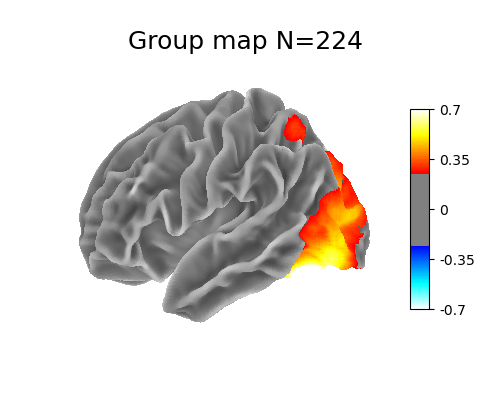

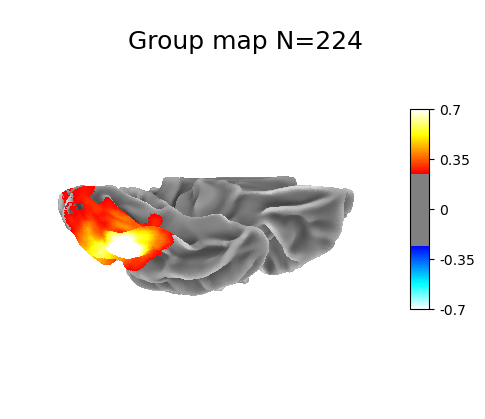

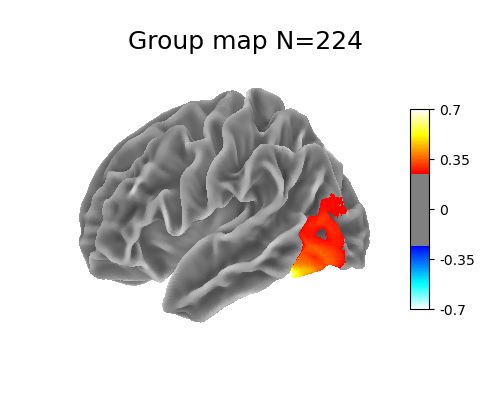

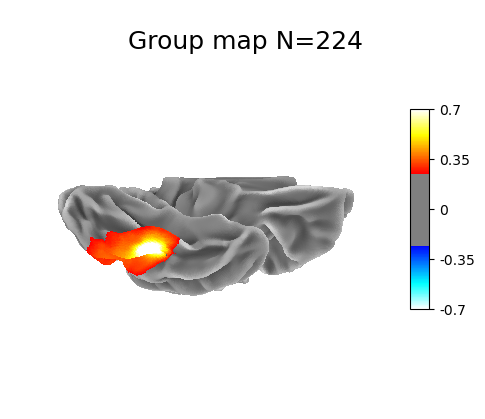

In [8]:
# When the seed ROI is not in the same hemisphere that we want to analyse, we actually need to load two surfaces:
# one to calculate the seed_timeseries of the source ROI, and another to extract all timeseries of all 
# vertices in the *other* hemisphere

for rr in range(len(roi_names)):
    # Allocate empty array for group data - N subjects * n vertices
    # We create a blank group_map here to avoid data bleeding from ROI to ROI in case there are missing values 
    if hemi == 'left':
        group_map = np.zeros(shape = (len(subs),white_left[0].shape[0]))
    elif hemi == 'right':
        group_map = np.zeros(shape = (len(subs),white_right[0].shape[0]))

    # Load ROI
    if atlas == False:
        cur_roi = surface.load_surf_data(roidir + roi_names[rr])
        cur_roi = cur_roi.astype(int) 
        print('Analyzing ROI ' + roidir + roi_names[rr])
    else:
        cur_roi = np.where(parcellation == labels.index(roi_names[rr]))[0]
        cur_roi = cur_roi.astype(int)
        # roi_names for the Atlas are bytes, not strings
        # (begin with 'b' --> need to be decoded inco UTF8)
        roi_names[rr] = roi_names[rr].decode()
        print('Analyzing ROI ' + roidir + ' ' + roi_names[rr])
        
    # Loop over subjects and compute connectivity for that ROI
    for ii in range(len(subs)):  
        output_subfilename = subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + '_' + corr_type + '_' + hemi[0] + 'h.npy'
        if os.path.exists(surfacedir + output_subfilename):
            print(output_subfilename +' exists, \nskipping sub # ' + str(ii))
            stat_map = np.load(surfacedir + output_subfilename)
            group_map[ii,:] = stat_map 
            
        else:
            # Load data for full hemisphere
            func_file = subs.iloc[ii] + '_task-' + task + '_'+ hemi[0] + 'h.gii'
            if not exists(surfdir + func_file):
                print('Cant find ' + func_file)
                continue
            else:
                print('Loading sub # ' + str(ii) + ' ' + func_file)
                run_data = surface.load_surf_data(surfdir + func_file)
                # saving as gii and loading the surface seems to transpose the data
                # we want our data to be vertices * timepoints
                if run_data.shape[0] < run_data.shape[1]:
                    run_data = np.transpose(run_data)
                print('Original Data Vertices by Timepoints')
                print(run_data.shape) 
                # Drop the same volumes from the second run as well - only for resting state
                if task =='rest':
                    droptp2 = [x + int(run_data.shape[1]/2) for x in droptp]
                    dropall = droptp + droptp2
                    print('dropping volumes: ' + str(dropall))

                elif task == 'movie':
                    dropall = droptp
                    print('dropping volumes: ' + str(dropall))

                run_data = np.delete(run_data,dropall,axis=1)
                print('After dropping initial 6 Timepoints, Vertices by Timepoints')
                print(run_data.shape) 
                # TBD - implement scrubbing

            # Load data for seed ROI if different from target hemisphere    
            if seed_hemi == hemi:
                run_data_seed = run_data.copy()
            else:
                func_file_seed = subs.iloc[ii] + '_task-' + task + '_'+ seed_hemi[0] + 'h.gii'
                print('Loading sub # ' + str(ii) + ' ' + func_file_seed)
                run_data_seed = surface.load_surf_data(surfdir + func_file_seed)
                # saving as gii and loading the surface seems to transpose the data
                # we want our data to be vertices * timepoints
                if run_data_seed.shape[0] < run_data_seed.shape[1]:
                    run_data_seed = np.transpose(run_data_seed)
                print('Original Data Vertices by Timepoints')
                print(run_data_seed.shape) 
                # we want to drop the same volumes from the second run as well - only for resting state
                if task =='rest':
                    droptp2 = [x + int(run_data_seed.shape[1]/2) for x in droptp]
                    dropall = droptp + droptp2
                    print('dropping volumes: ' + str(dropall))

                elif task == 'movie':
                    dropall = droptp
                    print('dropping volumes: ' + str(dropall))

                run_data_seed = np.delete(run_data_seed,dropall,axis=1)
                print('After dropping initial 6 Timepoints, Vertices by Timepoints')
                print(run_data_seed.shape) 
                
                
            # Compute the mean time series for the ROI
            seed_timeseries = np.nanmean(run_data_seed[cur_roi], axis=0)
            # To plot mean timeseries:
            fig, ax = plt.subplots(figsize =(4, 3))
            ax.plot(seed_timeseries)
            ax.set_title('Seed timeseries ' + subs.iloc[ii] + ' ' + roi_names[rr])
            ax.set_xlabel('Volume number')
            ax.set_ylabel('Normalized signal')
            print()

            # Compute correlations between the seed timeseries and each vertex
            stat_map = np.zeros(run_data.shape[0])
            for i in range(run_data.shape[0]): # this loops through the vertices
                stat_map[i] = stats.pearsonr(seed_timeseries, run_data[i])[0]

            print('computing stat_map ' + subs.iloc[ii])
            if corr_type == 'fisherz':
            # Fisher transform the map
                stat_map = np.arctanh(stat_map)

            # Save as a gifti that could be loaded into freeview
            if saveMaps:
                targetFile = surfacedir + subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + '_' + corr_type + '_'+hemi[0]+'h.curv'
                if not os.path.exists(targetFile):
                    nib.freesurfer.io.write_morph_data(targetFile,stat_map)

            # Add the stat map to the group stat map
            group_map[ii,:] = stat_map 

            # Save individual correlation maps - this way we can use a csv with 
            # a list of subjects and create a group npy from selected subjects
            np.save(surfacedir + output_subfilename,stat_map)

            # Plot the seed-based connectivity
            figTitle = subs.iloc[ii] + ' ' + roi_names[rr]

            if createFigs:
                if saveFigs:
                    output_filel = imagedir+os.path.splitext(output_subfilename)[0] + '_lateral.png'
                    output_filev = imagedir+os.path.splitext(output_subfilename)[0] + '_ventral.png'
                    print('Saving ' + output_filel)
                else: 
                    output_filel = None
                    output_filev = None

                plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=stat_map,
                hemi=hemi, threshold = .3, vmax=0.7, view='lateral', colorbar=True,
                bg_map=fsaverage['curv_'+ hemi], title=figTitle, output_file = output_filel)
                print()
                #plt.close()

                plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=stat_map,
                hemi=hemi, threshold = .3, vmax=0.7, view='ventral', colorbar=True,
                bg_map=fsaverage['curv_' + hemi], title=figTitle, output_file = output_filev)
                print()
                #plt.close()
            
    # outside the subject loop, save map of mean connectivity across the entire sample
    print('Calculating mean connectivity for ' + roi_names[rr])
    group_mean = np.mean(group_map, axis = 0)

    # Save map of group mean
    output_groupfilename = surfacedir + 'GroupMap_task-' + task + '_' + roi_names[rr] + '_N' + str(len(subs)) + '_' + corr_type + '_' + hemi[0]+'h'
    if saveFigs:
        output_file = output_groupfilename+ '_lateral.png'
        output_file_v = str.replace(output_file,'lateral','ventral')
    else:
        output_file = None
        output_file_v = None

    plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=group_mean,
    hemi=hemi, threshold = .25, vmax=0.7, view='lateral', colorbar=True,
    bg_map=fsaverage['curv_' + hemi],title='Group map N=' + str(len(subs)), output_file = output_file)
    print()
    plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=group_mean,
    hemi=hemi, threshold = .25, vmax=0.7, view='ventral', colorbar=True,
    bg_map=fsaverage['curv_' + hemi],title='Group map N=' + str(len(subs)), output_file = output_file_v)
    print()
    
    if saveGroup:
        nib.freesurfer.io.write_morph_data(output_groupfilename+ '.curv',group_mean)        
        #save also as numpy array
        np.save(output_groupfilename,group_map)

In [59]:
subs = [os.path.basename(x) for x in glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/surface/statMaps' + '/sub-*lh_pOTS_chars.label_fisherz_rh.npy')]
print('Found ' + str(len(subs)) + ' subjects in surfdir')

Found 0 subjects in surfdir


[-0.02297087  0.43743939 -0.09172817 ...  0.34100834  0.32465085
  0.19751657]


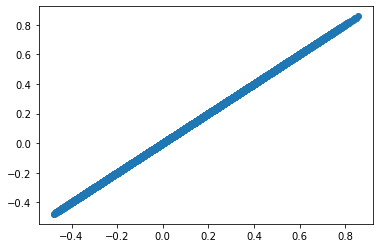

In [84]:
# Test assignment of subject map to group map
test_ind  = 1
roi_ind = 1
output_subfilename = surfacedir + subs.iloc[test_ind] + '_task-' + task + '_' + roi_names[roi_ind] + corr_type + '_'+hemi[0]+'h.npy'
test_sub = np.load(output_subfilename)
print(test_sub)

output_groupfilename = surfacedir + 'GroupMap_task-' + task + '_' + roi_names[roi_ind] + '_N' + str(sub_count) + '_' + corr_type + '_'+hemi[0]+'h.npy'
test_group = np.load(output_groupfilename)
test_group[test_ind]
plt.scatter(test_sub,test_group[test_ind])